In [25]:
!pip install holidays 
!pip install folium 
!pip install shapely 
!pip install scikit-learn
!pip install matplotlib 
!pip install seaborn 

In [10]:
!pip uninstall xgboost -y
!pip install xgboost

Found existing installation: xgboost 3.0.5
Uninstalling xgboost-3.0.5:
  Successfully uninstalled xgboost-3.0.5
  Using cached xgboost-3.0.5-py3-none-macosx_10_15_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.5-py3-none-macosx_10_15_x86_64.whl (2.2 MB)


In [1]:
# All imports and setup
import os, math, json, sys, warnings
from datetime import datetime, timezone
import numpy as np
import pandas as pd
from tqdm import tqdm
import h3
import pytz
import holidays
import requests
import folium
from shapely.geometry import Polygon
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import average_precision_score, brier_score_loss
from xgboost import XGBClassifier

# Setup
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)
os.chdir("..")  # Go to project root
print("Current working directory:", os.getcwd())

Current working directory: /Users/michellechang/ac215_project


## 0) Configuration

In [2]:
RAW_CSV = "/Users/michellechang/Downloads/US_Accidents_March23.csv"  #change
OUT_DIR = "nb_artifacts"                       # notebook outputs go here
# Los Angeles
BBOX = {
    "min_lat": 33.5,
    "min_lng": -119.0,
    "max_lat": 34.9,
    "max_lng": -117.0
}

H3_RES = 8

# Time window in UTC (panel range)
START_UTC = "2022-01-01T00:00:00Z"
END_UTC   = "2023-01-01T00:00:00Z"

# Negative sampling fraction (keep this % of negatives)
NEG_FRAC = 0.05
RANDOM_SEED = 42

# Model params
XGB_PARAMS = dict(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.06,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
)

# Evaluation splits (forward chaining)
TRAIN_END = "2022-07-01T00:00:00Z"
VAL_END   = "2022-10-01T00:00:00Z"
TEST_END  = "2023-01-01T00:00:00Z"

TOPK = 50


In [3]:
import os
os.chdir("..")  # go up one level from notebooks/ to project root
print("Current working directory:", os.getcwd())


Current working directory: /Users/michellechang


In [4]:
RAW_CSV

'/Users/michellechang/Downloads/US_Accidents_March23.csv'

## 1) Load & filter US‑Accidents

In [5]:
#assert os.path.exists(RAW_CSV), f"Place the Kaggle CSV at: {RAW_CSV}"

# must-have
base_cols = ["ID","Start_Time","Start_Lat","Start_Lng","City","County","State","Timezone", "Severity"]

# nice-to-have infra columns (some files may miss a few)
infra_cols = [
    "Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway",
  "Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"
]


# detect what’s present in this CSV
header_cols = pd.read_csv(RAW_CSV, nrows=0).columns.tolist()
available_infra = [c for c in infra_cols if c in header_cols]

usecols = list(dict.fromkeys(base_cols + available_infra))  # de-dup
acc = pd.read_csv(RAW_CSV, usecols=usecols, low_memory=False)
len_before = len(acc)

# bbox filter
acc = acc[(acc.Start_Lat >= BBOX["min_lat"]) & (acc.Start_Lat <= BBOX["max_lat"]) &
          (acc.Start_Lng >= BBOX["min_lng"]) & (acc.Start_Lng <= BBOX["max_lng"])].copy()

# timestamps
acc["Start_Time"] = pd.to_datetime(acc["Start_Time"], utc=True, errors="coerce")
acc = acc.dropna(subset=["Start_Time","Start_Lat","Start_Lng"])

# time window
start_utc = pd.to_datetime(START_UTC, utc=True)
end_utc   = pd.to_datetime(END_UTC, utc=True)
acc = acc[(acc["Start_Time"] >= start_utc) & (acc["Start_Time"] < end_utc)].copy()

print(f"Loaded {len_before:,} rows; after bbox/time filters: {len(acc):,} rows")
print("Infra columns loaded:", available_infra)

Loaded 7,728,394 rows; after bbox/time filters: 122,739 rows
Infra columns loaded: ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']


In [6]:
import requests

city = "Los Angeles, California"
url = f"https://nominatim.openstreetmap.org/search?q={city}&format=json"

headers = {"User-Agent": "accident-risk-demo/1.0 (lucchen@harvard.edu)"}

r = requests.get(url, headers=headers)
r.raise_for_status()
data = r.json()

bbox = data[0]["boundingbox"]
print("Bounding box:", bbox)


Bounding box: ['33.6595410', '34.3373060', '-118.6681798', '-118.1552983']


In [7]:
df = pd.read_csv(RAW_CSV)
df

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.010,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.010,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.010,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.010,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.010,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7728389,A-7777757,Source1,2,2019-08-23 18:03:25,2019-08-23 18:32:01,34.002480,-117.379360,33.99888,-117.37094,0.543,At Market St - Accident.,Pomona Fwy E,Riverside,Riverside,CA,92501,US,US/Pacific,KRAL,2019-08-23 17:53:00,86.0,86.0,40.0,28.92,10.0,W,13.0,0.00,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
7728390,A-7777758,Source1,2,2019-08-23 19:11:30,2019-08-23 19:38:23,32.766960,-117.148060,32.76555,-117.15363,0.338,At Camino Del Rio/Mission Center Rd - Accident.,I-8 W,San Diego,San Diego,CA,92108,US,US/Pacific,KMYF,2019-08-23 18:53:00,70.0,70.0,73.0,29.39,10.0,SW,6.0,0.00,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
7728391,A-7777759,Source1,2,2019-08-23 19:00:21,2019-08-23 19:28:49,33.775450,-117.847790,33.77740,-117.85727,0.561,At Glassell St/Grand Ave - Accident. in the ri...,Garden Grove Fwy,Orange,Orange,CA,92866,US,US/Pacific,KSNA,2019-08-23 18:53:00,73.0,73.0,64.0,29.74,10.0,SSW,10.0,0.00,Partly Cloudy,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day
7728392,A-7777760,Source1,2,2019-08-23 19:00:21,2019-08-23 19:29:42,33.992460,-118.403020,33.98311,-118.39565,0.772,At CA-90/Marina Fwy/Jefferson Blvd - Accident.,San Diego Fwy S,Culver City,Los Angeles,CA,90230,US,US/Pacific,KSMO,2019-08-23 18:51:00,71.0,71.0,81.0,29.62,10.0,SW,8.0,0.00,Fair,False,False,False,False,False,Fa

INFRASTRUCTURE PRESENCE ANALYSIS
                   Count  Percentage
Traffic_Signal   1143772       14.80
Crossing          873763       11.31
Junction          571342        7.39
Stop              214371        2.77
Station           201901        2.61
Amenity            96334        1.25
Railway            66979        0.87
Give_Way           36582        0.47
No_Exit            19545        0.25
Traffic_Calming     7598        0.10
Bump                3514        0.05
Roundabout           249        0.00
Turning_Loop           0        0.00

Total accidents: 7728394
Accidents with NO infrastructure: 5427044 (70.22%)
Accidents with at least ONE infrastructure: 2301350 (29.78%)


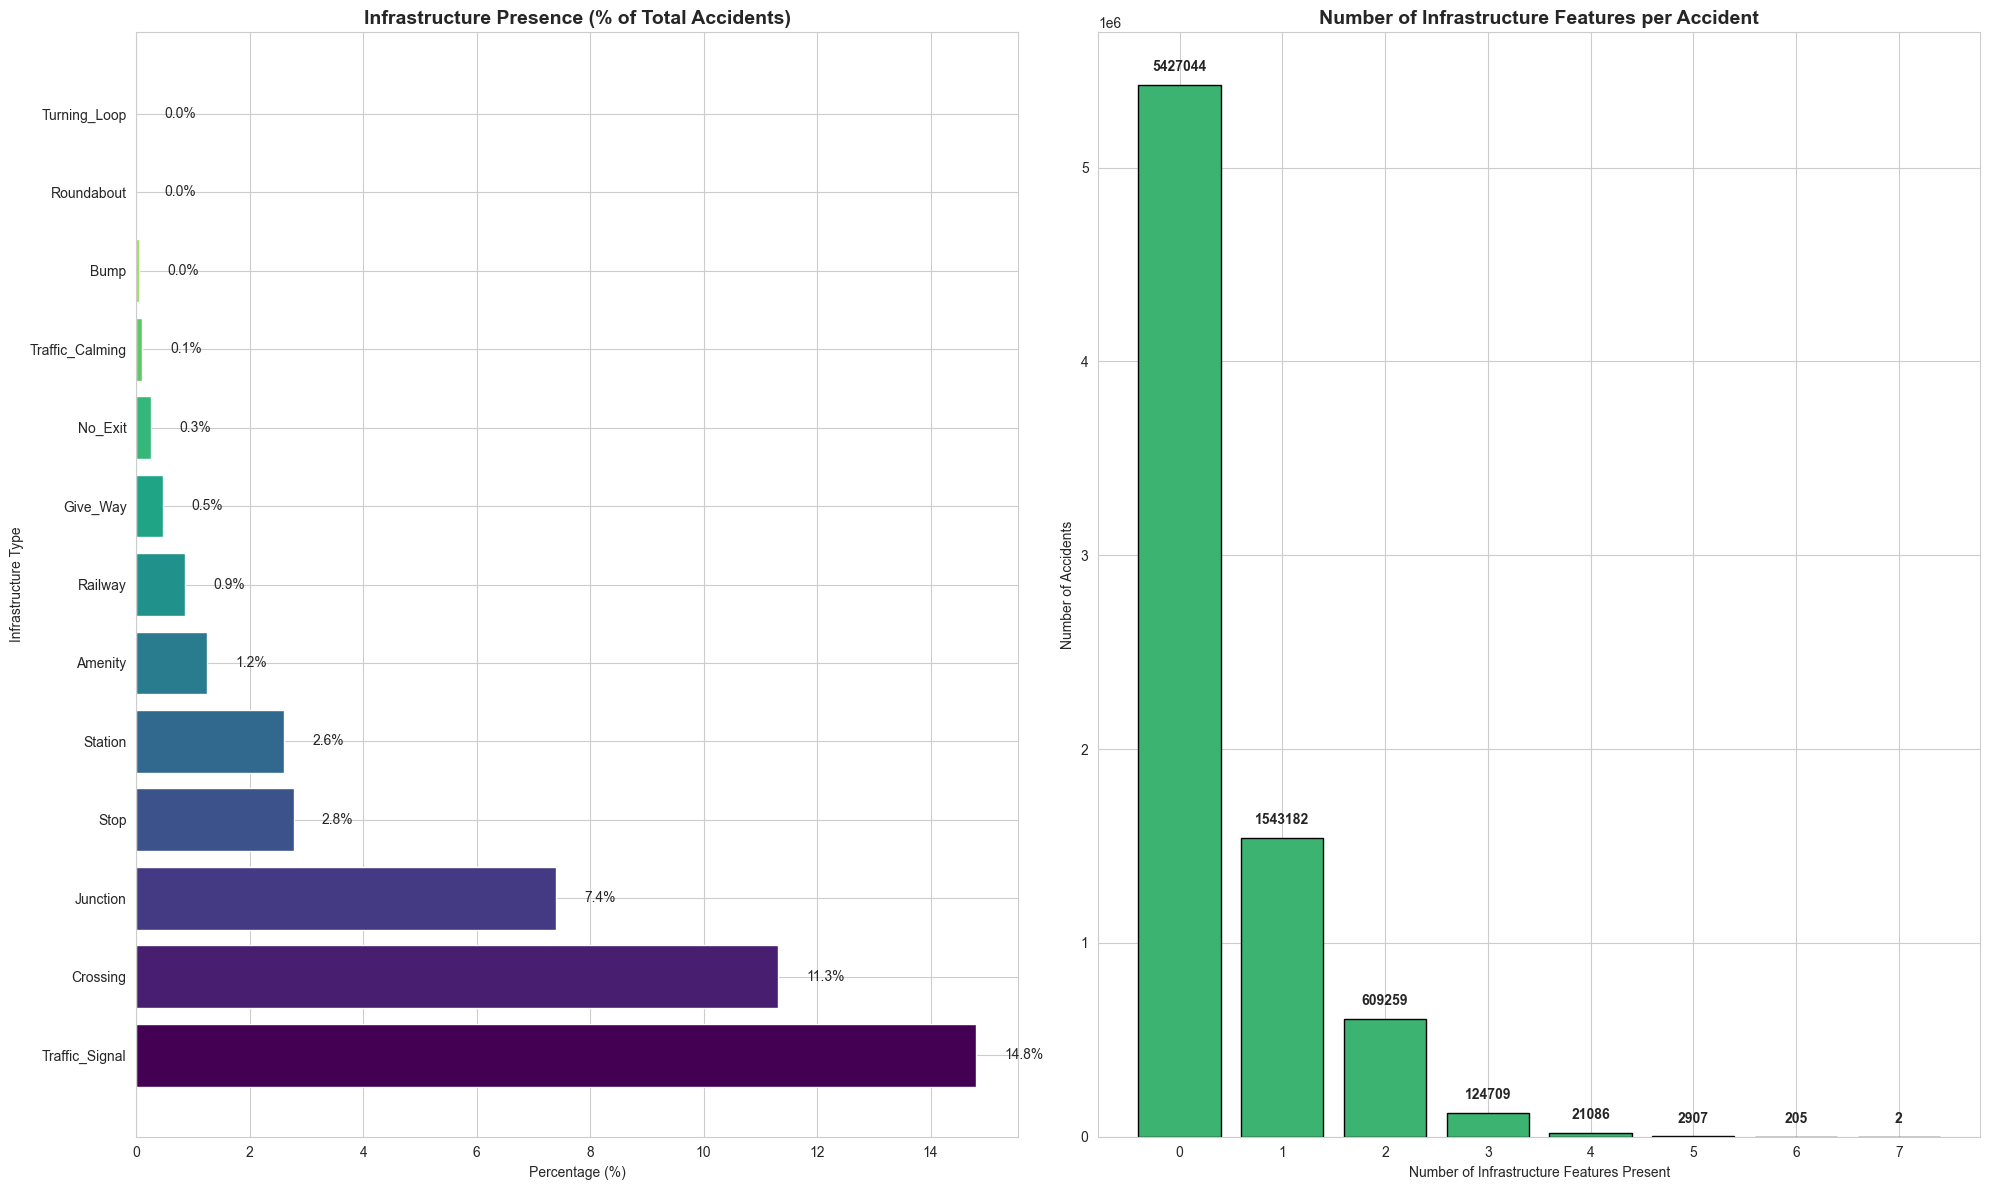


TOP 15 INFRASTRUCTURE COMBINATIONS
 1. None                                               : 5427044 (70.22%)
 2. Junction                                           : 548556 ( 7.10%)
 3. Traffic_Signal                                     : 545353 ( 7.06%)
 4. Crossing, Traffic_Signal                           : 423965 ( 5.49%)
 5. Crossing                                           : 202360 ( 2.62%)
 6. Stop                                               : 127658 ( 1.65%)
 7. Station                                            :  67723 ( 0.88%)
 8. Crossing, Stop                                     :  48705 ( 0.63%)
 9. Crossing, Station, Traffic_Signal                  :  39522 ( 0.51%)
10. Amenity                                            :  24984 ( 0.32%)
11. Station, Traffic_Signal                            :  24060 ( 0.31%)
12. Crossing, Station                                  :  20973 ( 0.27%)
13. Amenity, Crossing, Traffic_Signal                  :  20538 ( 0.27%)
14. Crossing, 

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

infra_cols = [
    "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway",
    "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop"
]

# Convert to boolean if needed
for col in infra_cols:
    df[col] = df[col].astype(bool)

# 1. Presence frequency and percentages
print("=" * 60)
print("INFRASTRUCTURE PRESENCE ANALYSIS")
print("=" * 60)
infra_counts = df[infra_cols].sum().sort_values(ascending=False)
infra_pct = (df[infra_cols].sum() / len(df) * 100).sort_values(ascending=False)

summary_df = pd.DataFrame({
    'Count': infra_counts,
    'Percentage': infra_pct.round(2)
})
print(summary_df)
print(f"\nTotal accidents: {len(df)}")
print(f"Accidents with NO infrastructure: {(~df[infra_cols].any(axis=1)).sum()} ({(~df[infra_cols].any(axis=1)).sum()/len(df)*100:.2f}%)")
print(f"Accidents with at least ONE infrastructure: {df[infra_cols].any(axis=1).sum()} ({df[infra_cols].any(axis=1).sum()/len(df)*100:.2f}%)")

# 2. Visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# Bar chart with percentages
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 1, len(infra_pct)))
bars = ax1.barh(infra_pct.index, infra_pct.values, color=colors)
ax1.set_title('Infrastructure Presence (% of Total Accidents)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Percentage (%)')
ax1.set_ylabel('Infrastructure Type')
# Add percentage labels on bars
for i, (bar, val) in enumerate(zip(bars, infra_pct.values)):
    ax1.text(val + 0.5, i, f'{val:.1f}%', va='center')


ax4 = axes[1]
infra_count_per_accident = df[infra_cols].sum(axis=1)
count_dist = infra_count_per_accident.value_counts().sort_index()
ax4.bar(count_dist.index, count_dist.values, color='mediumseagreen', edgecolor='black')
ax4.set_title('Number of Infrastructure Features per Accident', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Infrastructure Features Present')
ax4.set_ylabel('Number of Accidents')
ax4.set_xticks(range(int(count_dist.index.max()) + 1))
# Add count labels on bars
for i, val in enumerate(count_dist.values):
    ax4.text(count_dist.index[i], val + max(count_dist.values)*0.01, str(val), 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 3. Most common combinations
print("\n" + "=" * 60)
print("TOP 15 INFRASTRUCTURE COMBINATIONS")
print("=" * 60)
df['infra_combo'] = df[infra_cols].apply(
    lambda row: ', '.join([col for col, val in row.items() if val]) if row.any() else 'None', 
    axis=1
)
top_combos = df['infra_combo'].value_counts().head(15)
for idx, (combo, count) in enumerate(top_combos.items(), 1):
    pct = count / len(df) * 100
    print(f"{idx:2d}. {combo:50s} : {count:6d} ({pct:5.2f}%)")
    

# 6. Statistical insights
print("\n" + "=" * 60)
print("KEY INSIGHTS")
print("=" * 60)
print(f"• Most common infrastructure: {infra_pct.index[0]} ({infra_pct.values[0]:.2f}%)")
print(f"• Least common infrastructure: {infra_pct.index[-1]} ({infra_pct.values[-1]:.2f}%)")
print(f"• Average number of infrastructure per accident: {infra_count_per_accident.mean():.2f}")
print(f"• Maximum infrastructure in single accident: {infra_count_per_accident.max()}")

# Find most correlated pairs
corr_matrix = df[infra_cols].corr()
np.fill_diagonal(corr_matrix.values, 0)
max_corr_idx = np.unravel_index(corr_matrix.values.argmax(), corr_matrix.shape)
print(f"• Most correlated pair: {infra_cols[max_corr_idx[0]]} & {infra_cols[max_corr_idx[1]]} (r={corr_matrix.values[max_corr_idx]:.3f})")

Rows in LA region: 534,689


,count,percent
Junction,54760,10.241467
Station,25216,4.716012
Crossing,21002,3.927891
Stop,8870,1.658908
Railway,8156,1.525373
Amenity,4122,0.770915
Bump,135,0.025248
Roundabout,14,0.002618


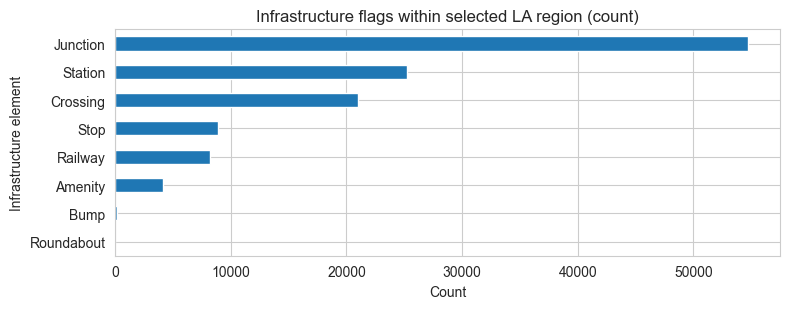

In [59]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.path import Path as MplPath

DATA_PATH = "/Users/michellechang/Downloads/US_Accidents_March23.csv"  

REGION_POLY = [
    
    (33.70, -118.90), (33.70, -117.60), (34.85, -117.60), (34.85, -118.90)
]

INFRA_COLS = [
    "Amenity","Bump","Crossing","GiveWay","Junction","NoExit","Railway",
    "Roundabout","Station","Stop","TrafficCalming","TrafficSignal","TurningLoop"
]

def bbox_to_poly(min_lat, min_lng, max_lat, max_lng):
    return [(min_lat, min_lng), (min_lat, max_lng), (max_lat, max_lng), (max_lat, min_lng)]

def load_data(path):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Data not found: {p}")
    if p.suffix.lower() == ".parquet":
        usecols = ["Start_Lat","Start_Lng"] + INFRA_COLS
        try:
            return pd.read_parquet(p, columns=usecols)
        except Exception:
            return pd.read_parquet(p)  # fallback if columns arg unsupported
    else:
        usecols = [c for c in ["Start_Lat","Start_Lng"] + INFRA_COLS]
        return pd.read_csv(p, usecols=lambda c: c in set(usecols), low_memory=False)

def to_bool_col(s):
    return (
        s.fillna(False)
         .astype(str)
         .str.strip()
         .str.lower()
         .map({"true":True,"t":True,"1":True,"yes":True,"y":True,"false":False,"f":False,"0":False,"no":False,"n":False})
         .fillna(False)
         .astype(bool)
    )

def points_in_poly(df, lat_col="Start_Lat", lng_col="Start_Lng", polygon=None):
    # matplotlib Path expects (x, y) = (lng, lat)
    poly_xy = [(lng, lat) for (lat, lng) in polygon]
    path = MplPath(poly_xy, closed=True)
    pts = df[[lng_col, lat_col]].to_numpy()
    return path.contains_points(pts)

df = load_data(DATA_PATH)
missing = [c for c in ["Start_Lat","Start_Lng"] if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Keep only infra columns that actually exist in your file
infra_cols_present = [c for c in INFRA_COLS if c in df.columns]
if not infra_cols_present:
    raise ValueError("No infrastructure columns found in this dataset.")

mask_region = points_in_poly(df, "Start_Lat", "Start_Lng", REGION_POLY)
df_la = df.loc[mask_region].copy()

# === 4) Calculate distribution ===
for c in infra_cols_present:
    df_la[c] = to_bool_col(df_la[c])

total = len(df_la)
counts = {c: int(df_la[c].sum()) for c in infra_cols_present}
percents = {c: (counts[c] / total * 100.0) if total else 0.0 for c in infra_cols_present}

dist = (
    pd.DataFrame({"count": counts, "percent": percents})
      .sort_values("count", ascending=False)
)

print(f"Rows in LA region: {total:,}")
display(dist)

# === 5) Simple bar chart ===
plt.figure(figsize=(8, max(3, 0.4*len(dist))))
dist["count"].iloc[::-1].plot(kind="barh")  # reverse for top at bottom
plt.title("Infrastructure flags within selected LA region (count)")
plt.xlabel("Count")
plt.ylabel("Infrastructure element")
plt.tight_layout()
plt.show()



## 2) Build H3 grid for bbox

In [8]:
import requests
import h3
import pandas as pd
import folium

# --- 1. Get Los Angeles city boundary polygon from OpenStreetMap ---
url = "https://nominatim.openstreetmap.org/search.php?q=Los+Angeles+California&polygon_geojson=1&format=json"
r = requests.get(url, headers={"User-Agent": "LA-grid-demo"}).json()
geojson_poly = r[0]["geojson"]  # Full GeoJSON

# --- 2. Create an H3 LatLngPoly shape object (required for H3 4.x) ---
coords = geojson_poly["coordinates"][0]  # Outer ring
poly = h3.LatLngPoly([(lat, lng) for lng, lat in coords])  # Note: swap lon→lat order

# --- 3. Generate hex cells ---
cells = list(h3.polygon_to_cells(poly, res=8))  # official new method (pleae dont chaneg this)
cells_df = pd.DataFrame({"h3_id": cells})
print(f"H3 res=8 → {len(cells_df):,} cells inside Los Angeles")

# --- 4. Visualize ---
# --- Visualization ---
m = folium.Map(location=[34.05, -118.25], zoom_start=10, tiles="cartodb positron")

# 
for h in cells_df["h3_id"]:
    boundary = h3.cell_to_boundary(h)
    folium.Polygon(
        locations=[(lat, lng) for lat, lng in boundary],
        color="blue",
        weight=0.5,
        fill=True,
        fill_opacity=0.3,
    ).add_to(m)
m



H3 res=8 → 1,738 cells inside Los Angeles


## 3) Build full cell × hour panel and label `y`

In [9]:
# --- Use the LA polygon-derived cells you already built above ---
H3_RES = 8  # must match the res you used in polygon_to_cells
cells_df = cells_df.drop_duplicates(subset=["h3_id"]).reset_index(drop=True)

print(f"[LA] H3 res {H3_RES}: {len(cells_df):,} cells")

# --- Build hours index and panel ---
hours = pd.date_range(start=start_utc, end=end_utc, freq="H",
                      inclusive="left", tz="UTC")
hours_df = pd.DataFrame({"ts_utc": hours})

cells_df["key"] = 1
hours_df["key"] = 1
panel = cells_df.merge(hours_df, on="key").drop(columns=["key"])

# Ensure tz-aware UTC
panel["ts_utc"] = pd.to_datetime(panel["ts_utc"], utc=True)

# --- Map accidents to (h3, hour) and count them ---
# 1) Compute each accident's h3 cell at the SAME resolution as the grid
acc = acc.copy()
acc["h3_id"] = acc.apply(
    lambda r: h3.latlng_to_cell(r["Start_Lat"], r["Start_Lng"], H3_RES), axis=1
)

# 2) Keep only accidents that fall inside the LA cell set
la_cells = set(cells_df["h3_id"].tolist())
acc = acc[acc["h3_id"].isin(la_cells)].copy()

# 3) Floor times to hour in UTC (assumes acc["Start_Time"] is already UTC-aware)
acc["ts_utc"] = pd.to_datetime(acc["Start_Time"], utc=True).dt.floor("H")

# 4) Count accidents per cell-hour
acc_counts = (acc.groupby(["h3_id", "ts_utc"])
                .size()
                .rename("cnt")
                .reset_index())

# --- Label merge ---
if "y" in panel.columns:
    panel = panel.drop(columns=["y"])

panel = panel.merge(acc_counts, on=["h3_id", "ts_utc"], how="left")
panel["y"] = (panel["cnt"].fillna(0) > 0).astype("int8")
panel = panel.drop(columns=["cnt"])

# # --- Optional: static road/infrastructure flags (if present in your CSV) ---
# infra_cols = [
#     "Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway",
#     "Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"
# ]
# available_infra = [c for c in infra_cols if c in acc.columns]
# print("Infra cols available:", available_infra)

# if available_infra:
#     def to01(s):
#         return s.map({True:1, False:0, "True":1, "False":0, 1:1, 0:0}).fillna(0).astype("int8")
#     for c in available_infra:
#         acc[c] = to01(acc[c])

#     static_feats = (
#         acc.groupby("h3_id")[available_infra]
#            .mean()                      # fraction of historical crashes with that attribute
#            .reset_index()
#     )

#     panel = panel.merge(static_feats, on="h3_id", how="left")
#     for c in available_infra:
#         panel[c] = panel[c].fillna(0).astype("float32")
# else:
#     print("No infrastructure columns in this CSV; skipping static road features.")

# --- Quick sanity checks ---
print(panel["y"].value_counts(dropna=False))

# Sample one accident row and verify its panel label
if len(acc) > 0:
    row = acc.sample(1, random_state=0).iloc[0]
    mask = (panel["h3_id"] == row["h3_id"]) & (panel["ts_utc"] == row["ts_utc"])
    print("Matches for sampled accident:", mask.sum())
    display(panel.loc[mask, ["h3_id","ts_utc","y"]].head())
else:
    print("Warning: No accidents landed inside the LA H3 grid for the given time window.")

[LA] H3 res 8: 1,738 cells
y
0    15203297
1       21583
Name: count, dtype: int64
Matches for sampled accident: 1


,h3_id,ts_utc,y
14556234,8829a19823fffff,2022-09-02 18:00:00+00:00,1


## 4) Time/holiday features

In [10]:
ts = pd.to_datetime(panel["ts_utc"], utc=True)

panel["hour"]       = ts.dt.hour.astype("int16")
panel["dow"]        = ts.dt.dayofweek.astype("int16")
panel["month"]      = ts.dt.month.astype("int16")
panel["is_weekend"] = (panel["dow"]>=5).astype("int8")

years = sorted(set(ts.dt.year.tolist()))
us_holidays = holidays.UnitedStates(years=years)
panel["is_holiday"] = ts.dt.date.astype("O").map(lambda d: 1 if d in us_holidays else 0).astype("int8")

## 5) Lag features (computed **strictly** from past values)

In [11]:
from meteostat import Stations, Hourly
import pandas as pd
import numpy as np

# Time window (infer if not defined)
START_UTC = pd.to_datetime(START_UTC, utc=True) if "START_UTC" in globals() else panel["ts_utc"].min()
END_UTC   = pd.to_datetime(END_UTC,   utc=True) if "END_UTC"   in globals() else panel["ts_utc"].max()

# Meteostat needs naive UTC
start_dt = START_UTC.tz_convert("UTC").tz_localize(None)
end_dt   = END_UTC.tz_convert("UTC").tz_localize(None)

# Map each res-8 cell to a station via a coarser parent (fewer lookups)
WEATHER_H3_RES = 7
cells_unique = panel[["h3_id"]].drop_duplicates().copy()
cells_unique["parent"] = cells_unique["h3_id"].map(lambda h: h3.cell_to_parent(h, WEATHER_H3_RES))
cells_unique["lat"] = cells_unique["h3_id"].map(lambda h: h3.cell_to_latlng(h)[0])
cells_unique["lng"] = cells_unique["h3_id"].map(lambda h: h3.cell_to_latlng(h)[1])

parent_centroids = (
    cells_unique.groupby("parent", as_index=False)
    .agg(lat=("lat","mean"), lng=("lng","mean"))
)

def nearest_station_id(lat, lng, k=20):
    s = Stations().nearby(lat, lng).fetch(k)
    return None if s.empty else s.index[0]

parent_centroids["station_id"] = [
    nearest_station_id(r.lat, r.lng) for r in parent_centroids.itertuples(index=False)
]

cell_to_station = cells_unique[["h3_id","parent"]].merge(
    parent_centroids[["parent","station_id"]], on="parent", how="left"
).drop(columns=["parent"])

# Fetch hourly weather per station
rename_map = {"temp":"temp_c","prcp":"precip_mm","wspd":"wind_kph",
              "pres":"pressure_hpa","rhum":"humidity_pct","vsby":"vis_km"}
station_ids = sorted(cell_to_station["station_id"].dropna().unique())
frames = [] 
for sid in station_ids:
    try:
        w = Hourly(sid, start_dt, end_dt, model=True).fetch()
        if w.empty: 
            continue
        w = w.tz_localize("UTC") if getattr(w.index, "tz", None) is None else w.tz_convert("UTC")
        w = w.reset_index().rename(columns={"time":"ts_utc"})
        for src, dst in rename_map.items():
            if src in w.columns:
                w[dst] = pd.to_numeric(w[src], errors="coerce")
        keep = ["ts_utc"] + [v for v in rename_map.values() if v in w.columns]
        w = w[keep].copy()
        w["station_id"] = sid
        frames.append(w)
    except Exception as e:
        print(f"[meteostat] skip {sid}: {e}")

weather_full = (pd.concat(frames, ignore_index=True) if frames else pd.DataFrame())
if not weather_full.empty:
    weather_full["ts_utc"] = pd.to_datetime(weather_full["ts_utc"], utc=True)
    weather_full = cell_to_station.merge(weather_full, on="station_id", how="left").drop(columns=["station_id"])

# Merge onto panel — no name collisions expected; validate to catch shape issues
wx_cols = [c for c in ["temp_c","precip_mm","wind_kph","pressure_hpa","humidity_pct","vis_km"] if c in weather_full.columns]
panel   = panel.merge(weather_full[["h3_id","ts_utc"] + wx_cols],
                      on=["h3_id","ts_utc"], how="left", validate="one_to_one")

In [12]:
acc = acc.copy()
acc["ts_utc"] = pd.to_datetime(acc["Start_Time"], utc=True, errors="coerce").dt.floor("H")
acc = acc.dropna(subset=["ts_utc","Start_Lat","Start_Lng"]).copy()
acc["h3_id"] = acc.apply(lambda r: h3.latlng_to_cell(r["Start_Lat"], r["Start_Lng"], H3_RES), axis=1)

if "Severity" in acc.columns:
    acc["Severity"] = pd.to_numeric(acc["Severity"], errors="coerce")
    sev_hour = (acc.groupby(["h3_id","ts_utc"], as_index=False)
                  .agg(Severity=("Severity","mean"))
                  .rename(columns={"Severity":"sev_mean_hour"})) 
else:
    sev_hour = panel[["h3_id","ts_utc"]].assign(sev_mean_hour=np.nan)

panel = panel.merge(sev_hour, on=["h3_id","ts_utc"], how="left", validate="one_to_one")
panel["sev_mean_hour"] = np.where(panel["y"].eq(0), 0.0, panel["sev_mean_hour"].fillna(0.0)).astype("float32")

avg_severity_h3 = (panel.groupby("h3_id")["sev_mean_hour"].mean()
                         .rename("avg_severity_h3").reset_index())
panel = panel.merge(avg_severity_h3, on="h3_id", how="left", validate="many_to_one")

panel 


,h3_id,ts_utc,y,hour,dow,month,is_weekend,is_holiday,temp_c,precip_mm,wind_kph,pressure_hpa,humidity_pct,sev_mean_hour,avg_severity_h3
0,8829a18c2dfffff,2022-01-01 00:00:00+00:00,0,0,5,1,1,1,12.0,0.0,24.0,1005.0,57.0,0.0,0.000228
1,8829a18c2dfffff,2022-01-01 01:00:00+00:00,0,1,5,1,1,1,12.2,0.0,24.1,1005.2,57.0,0.0,0.000228
2,8829a18c2dfffff,2022-01-01 02:00:00+00:00,0,2,5,1,1,1,11.1,0.0,22.3,1005.6,57.0,0.0,0.000228
3,8829a18c2dfffff,2022-01-01 03:00:00+00:00,0,3,5,1,1,1,10.6,0.0,25.9,1006.7,56.0,0.0,0.000228
4,8829a18c2dfffff,2022-01-01 04:00:00+00:00,0,4,5,1,1,1,10.6,0.0,22.3,1007.2,52.0,0.0,0.000228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15224875,8829a1c421fffff,2022-12-31 19:00:00+00:00,0,19,5,12,1,0,13.3,<NA>,14.8,1016.1,93.0,0.0,0.000000
15224876,8829a1c421fffff,2022-12-31 20:00:00+00:00,0,20,5,12,1,0,13.3,<NA>,18.4,1015.1,93.0,0.0,0.000000
15224877,8829a1c421fffff,2022-12-31 21:00:00+00:00,0,21,5,12,1,0,13.3,0.5,13.0,1014.1,97.0,0.0,0.000000
15224878,8829a1c421fffff,2022-12-31 22:00:00+00:00,0,22,5,12,1,0,13.9,<NA>,13.0,1013.2,93.0,0.0,0.000000


In [13]:
panel = panel.sort_values(["h3_id","ts_utc"])
g   = panel.groupby("h3_id", group_keys=False)
y   = g["y"]
cum = y.cumsum().shift(1).fillna(0) 

def past_sum(s, e):  
    return (cum.shift(s) - cum.shift(e)).fillna(0)

panel["lag_1h"]     = past_sum(1, 1)
panel["lag_2_3h"]   = past_sum(3, 2)
panel["lag_4_24h"]  = past_sum(24, 4)
panel["lag_1_7d"]   = past_sum(168, 24)
panel["lag_8_30d"]  = past_sum(720, 168)

panel["hour"] = panel["ts_utc"].dt.hour.astype("int16")
panel["dow"]  = panel["ts_utc"].dt.dayofweek.astype("int16")
panel 

,h3_id,ts_utc,y,hour,dow,month,is_weekend,is_holiday,temp_c,precip_mm,wind_kph,pressure_hpa,humidity_pct,sev_mean_hour,avg_severity_h3,lag_1h,lag_2_3h,lag_4_24h,lag_1_7d,lag_8_30d
3285000,8829a11009fffff,2022-01-01 00:00:00+00:00,0,0,5,1,1,1,13.0,0.0,14.0,1007.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3285001,8829a11009fffff,2022-01-01 01:00:00+00:00,0,1,5,1,1,1,13.0,0.0,0.0,1007.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3285002,8829a11009fffff,2022-01-01 02:00:00+00:00,0,2,5,1,1,1,10.0,0.0,18.4,1008.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3285003,8829a11009fffff,2022-01-01 03:00:00+00:00,0,3,5,1,1,1,10.0,0.0,24.1,1009.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3285004,8829a11009fffff,2022-01-01 04:00:00+00:00,0,4,5,1,1,1,9.0,0.0,20.5,1009.4,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4721635,8829a5756dfffff,2022-12-31 19:00:00+00:00,0,19,5,12,1,0,16.0,0.0,13.0,1017.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4721636,8829a5756dfffff,2022-12-31 20:00:00+00:00,0,20,5,12,1,0,15.0,0.2,9.0,1015.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4721637,8829a5756dfffff,2022-12-31 21:00:00+00:00,0,21,5,12,1,0,15.5,0.5,21.6,1015.2,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4721638,8829a5756dfffff,2022-12-31 22:00:00+00:00,0,22,5,12,1,0,15.0,0.2,19.0,1014.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
cutoff    = panel["ts_utc"].quantile(0.80)
train_idx = panel["ts_utc"] < cutoff
valid_idx = ~train_idx

avg_wx_h3_train = (
    panel.loc[train_idx].groupby("h3_id")[wx_cols]
         .mean()
         .add_suffix("__avg_h3")
         .reset_index()
)
panel = panel.merge(avg_wx_h3_train, on="h3_id", how="left", validate="many_to_one")

train_avg_only = avg_wx_h3_train.drop(columns=["h3_id"])
fill_vals = train_avg_only.median()
for c in train_avg_only.columns:
    panel[c] = panel[c].fillna(fill_vals[c]).astype("float32")

for c in wx_cols:
    panel[f"{c}__anom"] = (panel[c] - panel[f"{c}__avg_h3"]).astype("float32")




In [15]:
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
import xgboost as xgb 

lag_cols  = ["lag_1h","lag_2_3h","lag_4_24h","lag_1_7d","lag_8_30d"]
time_cols = ["hour","dow"]
anom_cols = [f"{c}__anom" for c in wx_cols if f"{c}__anom" in panel.columns]

FEATURES = ["avg_severity_h3"] + lag_cols + time_cols + anom_cols   # anomalies help with collinearity
FEATURES = [c for c in FEATURES if c in panel.columns]
TARGET   = "y"

X_train = panel.loc[train_idx, FEATURES].copy()
y_train = panel.loc[train_idx, TARGET].astype(int).values
X_valid = panel.loc[valid_idx, FEATURES].copy()

y_valid = panel.loc[valid_idx, TARGET].astype(int).values

# Optional: prune near-duplicates (|corr|>0.98) on TRAIN only
def corr_prune(df, thresh=0.98):
    corr  = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop  = [col for col in upper.columns if any(upper[col] > thresh)]
    keep  = [c for c in df.columns if c not in drop]
    return keep, drop

keep, dropped = corr_prune(X_train.fillna(0), 0.98)
if dropped:
    print("Pruned (high corr):", dropped)
    X_train, X_valid, FEATURES = X_train[keep], X_valid[keep], keep

model = xgb.XGBClassifier(
    n_estimators=2000, learning_rate=0.05,
    max_depth=6, min_child_weight=50,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, objective="binary:logistic",
    eval_metric=["aucpr", "auc", "logloss"],
    early_stopping_rounds=20,
    n_jobs=-1, tree_method="hist", random_state=0
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],  # last is monitored
    verbose=100
)

print("Best iteration:", model.best_iteration)
print("Best aucpr@validation_1:", model.best_score)

# Use best iteration for predictions
proba_valid = model.predict_proba(
    X_valid, iteration_range=(0, model.best_iteration + 1)
)[:, 1]

print({
    "AUC": roc_auc_score(y_valid, proba_valid),
    "PR-AUC": average_precision_score(y_valid, proba_valid),
    "LogLoss": log_loss(y_valid, proba_valid)
})


[0]	validation_0-aucpr:0.01504	validation_0-auc:0.90520	validation_0-logloss:0.01080	validation_1-aucpr:0.00947	validation_1-auc:0.88598	validation_1-logloss:0.00842
[100]	validation_0-aucpr:0.02565	validation_0-auc:0.94212	validation_0-logloss:0.00844	validation_1-aucpr:0.01543	validation_1-auc:0.93236	validation_1-logloss:0.00678
[109]	validation_0-aucpr:0.02603	validation_0-auc:0.94243	validation_0-logloss:0.00842	validation_1-aucpr:0.01545	validation_1-auc:0.93231	validation_1-logloss:0.00678
Best iteration: 105
Best aucpr@validation_1: 0.00678263137517433
{'AUC': 0.9323384395289663, 'PR-AUC': 0.015523360029973201, 'LogLoss': 0.00678263137754183}


In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score

t = 0.02  # pick your threshold
y_pred = (proba_valid >= t).astype(int)

# Confusion matrix with explicit order [0, 1]
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred, labels=[0, 1]).ravel()

print({
    "threshold": float(t),
    "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
    "precision": precision_score(y_valid, y_pred, zero_division=0),
    "recall":    recall_score(y_valid, y_pred, zero_division=0),
    "specificity": tn / (tn + fp + 1e-12)
})



{'threshold': 0.02, 'TP': 686, 'FP': 32632, 'FN': 2667, 'TN': 3008991, 'precision': 0.020589471156732098, 'recall': 0.2045929018789144, 'specificity': 0.9892715172130142}


In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss

feat_cols = X_train.columns.tolist()
X_train = X_train[feat_cols].apply(pd.to_numeric, errors="coerce").astype("float32")
X_valid = X_valid[feat_cols].apply(pd.to_numeric, errors="coerce").astype("float32")
y_train = np.asarray(y_train, dtype=np.int32)
y_valid = np.asarray(y_valid, dtype=np.int32)

rf = RandomForestClassifier(
    n_estimators=600,
    criterion="gini",
    max_depth=18,            
    min_samples_leaf=50,      
    max_features="sqrt",
    class_weight="balanced_subsample",
    bootstrap=True, oob_score=True,
    n_jobs=-1, random_state=0
)
rf.fit(X_train, y_train)

# 2) Metrics
proba_valid = rf.predict_proba(X_valid)[:, 1]
print({
    "AUC": roc_auc_score(y_valid, proba_valid),
    "PR-AUC": average_precision_score(y_valid, proba_valid),
    "LogLoss": log_loss(y_valid, proba_valid),
    "OOB": rf.oob_score_
})

gini_imp = (pd.Series(rf.feature_importances_, index=feat_cols)
              .sort_values(ascending=False)
              .rename("gini_importance"))
display(gini_imp.head(20))

ax = gini_imp.head(20).iloc[::-1].plot(kind="barh", figsize=(6,6))
ax.set_title("Random Forest Gini Importances (Top 20)")
ax.set_xlabel("Mean decrease in Gini impurity")


## 6 get weather data using meteostat integration

temp_c: Air temperature, measured 2 m above ground level.  Represents the ambient air temperature for that hour.

precip_mm: Hourly total precipitation (liquid equivalent of rain, drizzle, snow, etc.). 0 = no precipitation during that hour.

wind_kph: Mean wind speed over the hour, measured at 10 m height.

pressure_hpa: Mean sea-level air pressure.  Standard atmospheric pressure ≈ 1013 hPa.

humidity_pct: Relative humidity – ratio of current air moisture to the maximum possible at that temperature (0–100 %).



In [ ]:
# ============================================================
# Best-of (LSTM / GRU / TCN) sequence model — pick by val PR-AUC
# ============================================================
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------------
# 1) Config
# ---------------------
W = 168                 # sequence window (hours); try 168 for a week
BATCH_SIZE = 256
EPOCHS = 18
LR = 1e-3
BETA = 2.0              # F-beta for threshold picking on val

# Choose features you already have in your panel:
NUM_FEATS = [c for c in [
    # history (you can keep as-is; no shift policing here)
    "lag_1h","lag_3h","lag_24h","lag_7d_sum","lag_30d_sum","lag_ewm_24h","lag_ewm_7d",
    # neighbor spillover (if created; ok to omit if not in panel)
    "k1_lag_1h","k1_lag_3h","k1_lag_24h","k1_lag_7d_sum",
    "k2_lag_1h","k2_lag_3h","k2_lag_24h","k2_lag_7d_sum",
    # weather (current+lags ok, we’re ignoring leakage)
    "temp_c","temp_c_lag1","temp_c_lag3_mean","temp_c_lag24_mean","temp_c_diff1","temp_c_anom24",
    "wind_kph","wind_kph_lag1","wind_kph_lag3_mean","wind_kph_lag24_mean","wind_kph_diff1","wind_kph_anom24",
    "pressure_hpa","pressure_hpa_lag1","pressure_hpa_lag3_mean","pressure_hpa_lag24_mean","pressure_hpa_diff1","pressure_hpa_anom24",
    "humidity_pct","humidity_pct_lag1","humidity_pct_lag3_mean","humidity_pct_lag24_mean","humidity_pct_diff1","humidity_pct_anom24",
    "precip_mm","precip_mm_lag3_sum","precip_mm_lag24_sum","rain_flag_3h","rain_flag_24h",
] if c in panel.columns]

CAT_FEATS = ["hour","dow","month","is_weekend","is_holiday"]
CAT_FEATS = [c for c in CAT_FEATS if c in panel.columns]

STATIC_FEATS = [c for c in [
    "Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway",
    "Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"
] if c in panel.columns]

# ---------------------
# 2) Prepare DataFrame
# ---------------------
need_cols = ["h3_id","ts_utc","y"] + NUM_FEATS + CAT_FEATS + STATIC_FEATS + ["split"]
df = panel[need_cols].copy()
df["ts_utc"] = pd.to_datetime(df["ts_utc"], utc=True)
df = df.sort_values(["h3_id","ts_utc"]).reset_index(drop=True)

# map cells
h3_list = df["h3_id"].drop_duplicates().tolist()
h3_to_idx = {h:i for i,h in enumerate(h3_list)}
df["h3_idx"] = df["h3_id"].map(h3_to_idx).astype("int32")

# normalize numeric (fit on train only)
train_mask = df["split"]=="train"
num_stats = {}
for c in NUM_FEATS:
    m = pd.to_numeric(df.loc[train_mask, c], errors="coerce").astype("float32")
    mu, sd = float(m.mean()), float(m.std() if m.std()>1e-6 else 1.0)
    num_stats[c] = (mu, sd)
    df[c] = ((pd.to_numeric(df[c], errors="coerce").astype("float32") - mu)/sd).fillna(0.0)

for c in CAT_FEATS:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype("int64")
for c in STATIC_FEATS:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype("float32")

groups = {gid: g for gid, g in df.groupby("h3_idx", sort=True)}

# ---------------------
# 3) Dataset
# ---------------------
class CellSeqDataset(Dataset):
    def __init__(self, groups, split, W, num_cols, cat_cols, static_cols):
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.static_cols = static_cols
        self.W = W
        self.samples = []
        for h3_idx, g in groups.items():
            g = g[g["split"]==split]
            if len(g) < W: 
                continue
            arr_num = g[num_cols].to_numpy(np.float32)
            arr_cat = g[cat_cols].to_numpy(np.int64) if cat_cols else None
            arr_static = g[static_cols].to_numpy(np.float32) if static_cols else None
            y = g["y"].astype("int64").to_numpy()
            for t in range(W-1, len(g)):
                Xn = arr_num[t-W+1:t+1]
                Xc = arr_cat[t-W+1:t+1] if arr_cat is not None else None
                Xs = arr_static[t] if arr_static is not None else None
                self.samples.append((h3_idx, Xn, Xc, Xs, y[t]))

    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        h3_idx, Xn, Xc, Xs, y = self.samples[i]
        return (
            torch.tensor(h3_idx, dtype=torch.long),
            torch.tensor(Xn, dtype=torch.float32),
            (torch.tensor(Xc, dtype=torch.long) if Xc is not None else torch.empty(0, dtype=torch.long)),
            (torch.tensor(Xs, dtype=torch.float32) if Xs is not None else torch.empty(0)),
            torch.tensor(y, dtype=torch.float32),
        )

def collate(batch):
    h_idx, Xn, Xc, Xs, y = zip(*batch)
    Xn = torch.stack(Xn)  # (B,W,Fnum)
    if Xc[0].numel() == 0:
        Xc = None
    else:
        Xc = torch.stack(Xc)  # (B,W,C)
    if Xs[0].numel() == 0:
        Xs = None
    else:
        Xs = torch.stack(Xs)  # (B,Fstatic)
    y = torch.stack(y)
    return (torch.tensor(h_idx, dtype=torch.long), Xn, Xc, Xs, y)

train_ds = CellSeqDataset(groups, "train", W, NUM_FEATS, CAT_FEATS, STATIC_FEATS)
val_ds   = CellSeqDataset(groups, "val",   W, NUM_FEATS, CAT_FEATS, STATIC_FEATS)
test_ds  = CellSeqDataset(groups, "test",  W, NUM_FEATS, CAT_FEATS, STATIC_FEATS)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)

# ---------------------
# 4) Models: LSTM / GRU / TCN
# ---------------------
class CatEmb(nn.Module):
    def __init__(self, cardinals, emb_dim=8):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, min(emb_dim, max(2,c))) for c in cardinals])
        self.out_dim = sum(e.embedding_dim for e in self.embs)
    def forward(self, Xc):  # (B,W,C)
        if Xc is None: return None
        embs = [emb(Xc[:,:,i]) for i, emb in enumerate(self.embs)]  # list of (B,W,Di)
        return torch.cat(embs, dim=-1)  # (B,W,sumD)

class RNNSeq(nn.Module):
    def __init__(self, kind, num_in, cat_card=None, static_in=0, hid=128, layers=1):
        super().__init__()
        self.cat = CatEmb(cat_card) if cat_card else None
        in_dim = num_in + (self.cat.out_dim if self.cat else 0)
        rnn = {"lstm": nn.LSTM, "gru": nn.GRU}[kind]
        self.rnn = rnn(in_dim, hid, num_layers=layers, batch_first=True)
        head_in = hid + static_in
        self.head = nn.Sequential(
            nn.Linear(head_in, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.25),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, Xn, Xc=None, Xs=None):
        # Xn: (B,W,F)
        if self.cat:
            Ec = self.cat(Xc)                       # (B,W,De)
            x = torch.cat([Xn, Ec], dim=-1)
        else:
            x = Xn
        seq, _ = self.rnn(x)                        # (B,W,H)
        h = seq[:,-1,:]                             # (B,H)
        if Xs is not None: h = torch.cat([h, Xs], dim=1)
        logit = self.head(h).squeeze(1)
        return torch.sigmoid(logit)

class Chomp1d(nn.Module):
    def __init__(self, chomp_size): super().__init__(); self.chomp_size=chomp_size
    def forward(self, x): return x[:,:,:-self.chomp_size]

class TCNBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, d=1, p=0.2):
        super().__init__()
        pad = (k-1)*d
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, k, padding=pad, dilation=d),
            Chomp1d(pad), nn.ReLU(), nn.BatchNorm1d(out_ch), nn.Dropout(p),
            nn.Conv1d(out_ch, out_ch, k, padding=pad, dilation=d),
            Chomp1d(pad), nn.ReLU(), nn.BatchNorm1d(out_ch), nn.Dropout(p),
        )
        self.down = nn.Conv1d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()
    def forward(self, x):
        out = self.net(x)
        return out + self.down(x)

class TCNSeq(nn.Module):
    def __init__(self, num_in, cat_card=None, static_in=0, hid=128, levels=4, k=3):
        super().__init__()
        self.cat = CatEmb(cat_card) if cat_card else None
        in_dim = num_in + (self.cat.out_dim if self.cat else 0)
        chs = [in_dim] + [hid]*levels
        blocks = []
        for i in range(levels):
            blocks.append(TCNBlock(chs[i], chs[i+1], k=k, d=2**i, p=0.2))
        self.tcn = nn.Sequential(*blocks)
        head_in = hid + static_in
        self.head = nn.Sequential(
            nn.Linear(head_in, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.25),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, Xn, Xc=None, Xs=None):
        # Xn: (B,W,F) -> transpose to (B,F,W)
        if self.cat:
            Ec = self.cat(Xc)                # (B,W,De)
            x = torch.cat([Xn, Ec], dim=-1)  # (B,W,F+De)
        else:
            x = Xn
        x = x.transpose(1,2)                 # (B, Fch, W)
        y = self.tcn(x)                      # (B, hid, W)
        h = y[:,:,-1]                        # (B, hid)
        if Xs is not None: h = torch.cat([h, Xs], dim=1)
        logit = self.head(h).squeeze(1)
        return torch.sigmoid(logit)

# ---------------------
# 5) Train & Select
# ---------------------
def run_train(model, train_loader, val_loader, epochs=EPOCHS, lr=LR):
    model = model.to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    bce = nn.BCELoss()
    best = {"pr": -1, "state": None}
    for ep in range(1, epochs+1):
        model.train()
        for _, Xn, Xc, Xs, y in train_loader:
            Xn, y = Xn.to(DEVICE), y.to(DEVICE)
            if Xc is not None: Xc = Xc.to(DEVICE)
            if Xs is not None: Xs = Xs.to(DEVICE)
            p = model(Xn, Xc, Xs)
            loss = bce(p, y)
            opt.zero_grad(); loss.backward(); opt.step()
        # val PR-AUC
        model.eval(); pv, yv = [], []
        with torch.no_grad():
            for _, Xn, Xc, Xs, y in val_loader:
                Xn = Xn.to(DEVICE)
                if Xc is not None: Xc = Xc.to(DEVICE)
                if Xs is not None: Xs = Xs.to(DEVICE)
                p = model(Xn, Xc, Xs).detach().cpu().numpy()
                pv.append(p); yv.append(y.numpy())
        pv = np.concatenate(pv) if pv else np.array([])
        yv = np.concatenate(yv) if yv else np.array([])
        pr = average_precision_score(yv, pv) if (yv.size and len(np.unique(yv))>1) else 0.0
        if pr > best["pr"]:
            best = {"pr": pr, "state": {k:v.cpu().clone() for k,v in model.state_dict().items()}}
        print(f"[{model.__class__.__name__}] epoch {ep:02d}  val PR-AUC={pr:.6f}")
    model.load_state_dict({k:v.to(DEVICE) for k,v in best["state"].items()})
    return model, best["pr"]

cat_card = [24,7,12,2,2] if CAT_FEATS else None
c_static = len(STATIC_FEATS)

candidates = {
    "LSTM": RNNSeq(kind="lstm", num_in=len(NUM_FEATS), cat_card=cat_card, static_in=c_static, hid=160, layers=1),
    "GRU" : RNNSeq(kind="gru",  num_in=len(NUM_FEATS), cat_card=cat_card, static_in=c_static, hid=160, layers=1),
    "TCN" : TCNSeq(num_in=len(NUM_FEATS), cat_card=cat_card, static_in=c_static, hid=192, levels=4, k=3),
}

results = {}
best_name, best_model, best_val = None, None, -1
for name, mdl in candidates.items():
    print(f"\n==== Train {name} ====")
    m, val_pr = run_train(mdl, train_loader, val_loader, epochs=EPOCHS, lr=LR)
    results[name] = val_pr
    if val_pr > best_val:
        best_val, best_name, best_model = val_pr, name, m

print("\nValidation PR-AUC per model:", {k: round(v,6) for k,v in results.items()})
print("→ Selected:", best_name, "with PR-AUC", round(best_val,6))

# ---------------------
# 6) Test evaluation
# ---------------------
best_model.eval(); pt, yt = [], []
with torch.no_grad():
    for _, Xn, Xc, Xs, y in test_loader:
        Xn = Xn.to(DEVICE)
        if Xc is not None: Xc = Xc.to(DEVICE)
        if Xs is not None: Xs = Xs.to(DEVICE)
        p = best_model(Xn, Xc, Xs).detach().cpu().numpy()
        pt.append(p); yt.append(y.numpy())
pt = np.concatenate(pt) if pt else np.array([])
yt = np.concatenate(yt) if yt else np.array([])

test_pr = average_precision_score(yt, pt) if (yt.size and len(np.unique(yt))>1) else 0.0
print("Test PR-AUC (prob ranking):", round(float(test_pr), 6))

# pick threshold on VAL by F-beta
best_model.eval(); pv, yv = [], []
with torch.no_grad():
    for _, Xn, Xc, Xs, y in val_loader:
        Xn = Xn.to(DEVICE)
        if Xc is not None: Xc = Xc.to(DEVICE)
        if Xs is not None: Xs = Xs.to(DEVICE)
        pv.append(best_model(Xn, Xc, Xs).detach().cpu().numpy()); yv.append(y.numpy())
pv = np.concatenate(pv) if pv else np.array([])
yv = np.concatenate(yv) if yv else np.array([])

prec, rec, thr = precision_recall_curve(yv, pv)
fb = (1+BETA**2)*prec*rec/(BETA**2*prec + rec + 1e-12)
best_t = float(thr[np.nanargmax(fb[:-1])]) if thr.size else 0.5
print("Chosen threshold (val, Fβ):", best_t)

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, brier_score_loss
y_pred = (pt >= best_t).astype(int)
print("Test precision:", round(float(precision_score(yt, y_pred, zero_division=0)),6))
print("Test recall   :", round(float(recall_score(yt, y_pred, zero_division=0)),6))
print("Test F1       :", round(float(f1_score(yt, y_pred, zero_division=0)),6))
print("Brier score   :", round(float(brier_score_loss(yt, np.clip(pt,1e-6,1-1e-6))),6))
print("Confusion:\n", pd.DataFrame(confusion_matrix(yt, y_pred),
                                    index=["Actual 0","Actual 1"],
                                    columns=["Pred 0","Pred 1"]))